# Embedded ML Lab - Excercise 4 - Pruning

Focus on structured pruning to save computation time. We will do this in three steps. 
* We will use a builtin-function, similar to previous l1 pruning, to sets whole output channels to zero + delete.  

* We will implement a function, similar to previous l1 pruning, to sets whole output channels to zero.  

* We will delete the zeroed-out channels and densify the network again to have a reduction in computation time.

* We will retrain the network to gain accuracy again.  

In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
# torch
import torch
from torch import nn
from torch.utils.data import Subset
from torchinfo import summary
from torchvision.transforms import v2
from torch.optim.lr_scheduler import ReduceLROnPlateau # Import ReduceLROnPlateau to reduce learning rate of optimizer after Plateau


# Scikit-learn libraires
from sklearn.model_selection import train_test_split

# EML libraires
from tinyyolov2_pruned import TinyYoloV2, PrunedTinyYoloV2, FusedTinyYoloV2, PrunedFusedTinyYoloV2
from utils.dataloader import VOCDataLoaderPerson
from utils.dataloader_v2 import VOCDataset
from utils.ap import ap, precision_recall_levels
from utils.yolo import nms, filter_boxes
from utils.loss import YoloLoss

# Other libraries
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import time
import tqdm
import copy

# Globals and Hyperparameters

In [3]:
# Weights
WEIGHTS_PATH = "./pruning_save3-7/"

# Number or Epochs for fine-tuning
NUM_EPOCHS               = 15
# Thresholds
CONFIDENCE_THRESHOLD     = 0.0
NMS_THRESHOLD            = 0.5

# Batch sizes
TRAIN_BATCH_SIZE         = 64
VALIDATION_BATCH_SIZE    = 64
TEST_BATCH_SIZE          = 64

# Dataset custom split ratios
TRAIN_DATASET_RATIO      = 0.70
TEST_DATASET_RATIO       = 0.15
VALIDATION_DATASET_RATIO = 0.15

# Function Definitions

## Utility Functions

### Size on Disk

In [4]:
def size_on_disk(state_dict: Dict) -> Tuple[int, int]:
    buff = io.BytesIO()
    torch.save(state_dict, buff)
    compressed_buff = gzip.compress(buff.getvalue(), compresslevel=9)
    return compressed_buff.__sizeof__(), buff.__sizeof__()

### Multiplications and Additions

In [5]:
def net_macs(model_class: torch.nn.Module, state_dict: Dict) -> int:
    net = model_class(num_classes=1)
    net.load_state_dict(state_dict, strict=False)
    res = summary(net, (1, 3, 320, 320), verbose=0)
    return res.total_mult_adds

### Plot function

In [6]:
def plot(data, xlabel='Execution time', save_path='plot.png'):
   
    data = copy.deepcopy(data)
    for (x, y, label) in data:
        x = np.array(x)/max(x)
        plt.plot(x, y, label=label, alpha=0.5)
        plt.scatter(x, y, alpha=0.5)
        
    plt.ylabel('Average Precision')
    plt.xlabel(xlabel)
    plt.legend()
        
    plt.savefig(save_path)
    plt.show()

### Timing evaluation

In [7]:
def net_time(net, test_loader):
    net.eval()

    t_start = time.time()

    for _, (inputs, _) in enumerate(test_loader):
        net.forward(inputs)
        break

    t_end = time.time()
    t = t_end - t_start

    return t

## Pruning Functions

### Structured Pruning

In [8]:
def l1_structured_pruning(state_dict: Dict, prune_ratio: float) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    # conv layer 3-7
    for num in range(5):
        conv_layer = state_dict.get('conv{}.weight'.format(num+3))
        
        # L1 norm of each output channels + mask
        out_channels_num = conv_layer.shape[0]
        out_channel_l1_norm = torch.zeros(conv_layer.shape[0])
        for out_channel in range(out_channels_num):
            out_channel_l1_norm[out_channel] = conv_layer[out_channel].cpu().abs().sum().item()
    
        threshold = np.percentile(out_channel_l1_norm.cpu().numpy(), prune_ratio*100)
        conv_mask = torch.where(out_channel_l1_norm<threshold, 0.0, 1.0)
    
        # Zero out the pruned channels
        for idx, keep in enumerate(conv_mask):
            if keep != 1.0:
                state_dict['conv{}.weight'.format(num+3)][idx] = 0
                # state_dict['conv{}.bias'.format(num+3)][idx] = 0
                
    return state_dict

In [9]:
def l1_structured_fused_pruning(state_dict: Dict, prune_ratio: float) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    # conv layer 3-7
    for num in range(5):
        conv_layer = state_dict.get('conv{}.weight'.format(num+3))
        
        # L1 norm of each output channels + mask
        out_channels_num = conv_layer.shape[0]
        out_channel_l1_norm = torch.zeros(conv_layer.shape[0])
        for out_channel in range(out_channels_num):
            out_channel_l1_norm[out_channel] = conv_layer[out_channel].cpu().abs().sum().item()
    
        threshold = np.percentile(out_channel_l1_norm.cpu().numpy(), prune_ratio*100)
        conv_mask = torch.where(out_channel_l1_norm<threshold, 0.0, 1.0)
    
        # Zero out the pruned channels
        for idx, keep in enumerate(conv_mask):
            if keep != 1.0:
                state_dict['conv{}.weight'.format(num+3)][idx] = 0
                state_dict['conv{}.bias'.format(num+3)][idx] = 0
                
    return state_dict

In [10]:
def count_pruned_weights(model_class, state_dict):
    model = model_class(num_classes=1)
    model.load_state_dict(state_dict, strict=False)

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            total_weights = module.weight.nelement()
            zero_weights = torch.sum(module.weight == 0).item()
            percentage = (zero_weights / total_weights) * 100
            
            print(f"{name}: {zero_weights}/{total_weights} weights are 0 ({percentage:.2f}%)")

### Densifying Model

In [11]:
def densify_state_dict(state_dict: Dict) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    # layer 3-7
    for num in range(5):
        conv_layer = state_dict.get('conv{}.weight'.format(num+3))
        bn_weight = state_dict.get('bn{}.weight'.format(num+3))
        bn_bias = state_dict.get('bn{}.bias'.format(num+3))
        bn_running_mean = state_dict.get('bn{}.running_mean'.format(num+3))
        bn_running_var = state_dict.get('bn{}.running_var'.format(num+3))

        # calc L1 norm of all output channels
        idxs = []
        out_channels_num = conv_layer.shape[0]
        for out_channel in range(out_channels_num):
            out_channel_l1_norm = conv_layer[out_channel].cpu().abs().sum().item()
    
            # get indices of not-zeroed out-channels   
            if out_channel_l1_norm != 0:
                idxs.append(out_channel)
        
        conv_layer = conv_layer[idxs,:,:,:]
        bn_weight = bn_weight[idxs]
        bn_bias = bn_bias[idxs]
        bn_running_mean = bn_running_mean[idxs]
        bn_running_var = bn_running_var[idxs]
    
        # update state dict
        state_dict['conv{}.weight'.format(num+3)] = conv_layer
        state_dict['bn{}.weight'.format(num+3)] = bn_weight
        state_dict['bn{}.bias'.format(num+3)] = bn_bias
        state_dict['bn{}.running_mean'.format(num+3)] = bn_running_mean
        state_dict['bn{}.running_var'.format(num+3)] = bn_running_var
        
        # prune input layer of next conv layer + update state dict
        conv_layer_next = state_dict.get('conv{}.weight'.format(num+3+1))
        conv_layer_next = conv_layer_next[:,idxs,:,:]
        state_dict['conv{}.weight'.format(num+3+1)] = conv_layer_next
    
    return state_dict

In [12]:
def densify_fused_state_dict(state_dict: Dict) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    # layer 3-7
    for num in range(5):
        conv_layer = state_dict.get('conv{}.weight'.format(num+3))
        conv_bias = state_dict.get('conv{}.bias'.format(num+3))

        # calc L1 norm of all output channels
        idxs = []
        out_channels_num = conv_layer.shape[0]
        for out_channel in range(out_channels_num):
            out_channel_l1_norm = conv_layer[out_channel].cpu().abs().sum().item()
    
            # get indices of not-zeroed out-channels   
            if out_channel_l1_norm != 0:
                idxs.append(out_channel)
        
        conv_layer = conv_layer[idxs,:,:,:]
        conv_bias = conv_bias[idxs]
    
        # update state dict
        state_dict['conv{}.weight'.format(num+3)] = conv_layer
        state_dict['conv{}.bias'.format(num+3)] = conv_bias
        
        # prune input layer of next conv layer + update state dict
        conv_layer_next = state_dict.get('conv{}.weight'.format(num+3+1))
        conv_layer_next = conv_layer_next[:,idxs,:,:]
        state_dict['conv{}.weight'.format(num+3+1)] = conv_layer_next
    
    return state_dict

## Training Functions

### Dataset

In [13]:
def split_dataset_custom(dataset: torch.utils.data.Dataset, train_ratio: float, test_ratio: float, validation_ratio: float, pipeline=None):
    if (train_ratio + validation_ratio + test_ratio != 1):
        raise ValueError("The sum of the ratios must be equal to 1.")

    dataset_size = len(dataset)
    indices = list(range(dataset_size))

    # Step 2: Split into train+validation and test
    train_validation_indices, test_indices = train_test_split(indices, test_size=int(test_ratio*dataset_size), random_state=42)
    # Step 3: Split train+validation into train and val
    train_indices, validation_indices = train_test_split(train_validation_indices, test_size=int(validation_ratio*dataset_size), random_state=42)

    # Create Subsets
    train_dataset = Subset(dataset, train_indices)
    validation_dataset = Subset(dataset, validation_indices)
    test_dataset = Subset(dataset, test_indices)

    if pipeline:
        train_dataset.transform = pipeline

    return train_dataset, validation_dataset, test_dataset

### Early Stopping

In [14]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0,
                 path='./pruning_save/checkpoint.pt',
                 best_model_path='./pruning_save/voc_fine_tuned.pt'):
        """
        Args:
            patience (int): How long to wait after last improvement.
            verbose (bool): If True, prints a message for each validation metric improvement.
            delta (float): Minimum change in the monitored metric to qualify as an improvement.
            path (str): Path to save the best model checkpoint.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.best_model_path = best_model_path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.avg_precision_min = 0 # Track the minimum average precision

    def __call__(self, avg_precision, model):
        score = avg_precision  # Positive because we maximize AP

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(avg_precision, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                torch.save(model.state_dict(), self.best_model_path)
        else:
            self.best_score = score
            self.save_checkpoint(avg_precision, model)
            self.counter = 0

    def save_checkpoint(self, avg_precision, model):
        """Save model when average precision increases."""
        if self.verbose:
            print(f"Average Precision increased ({self.avg_precision_min:.6f} --> {avg_precision:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.avg_precision_min = avg_precision

### train, validate and test

In [15]:
def train(net: nn.Module, data_loader: torch.utils.data.DataLoader, optimizer, criterion, device):
    """
    Description:
    This function trains the network for one epoch and returns average loss.

    Args:
    net: the network to train
    data_loader: the data loader for the training set
    optimizer: the optimizer to use for training
    criterion: the loss function to use for training
    device: the device to use for training
    """

    total_loss = 0

    net.train()
    # Move weights to device
    net.to(device)

    for idx, (input, target) in enumerate(data_loader):
        # Move Inputs and targets to Device
        input  = input.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        #Yolo head is implemented in the loss for training, therefore yolo=False
        output = net(input, yolo=False)
        loss, _ = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(data_loader)

    return average_loss

In [16]:
def validate(net: nn.Module, data_loader: torch.utils.data.DataLoader, device):
    """
    Description:
    This function is used to validate the network. It is currently needed for
    early stopping and learning rate adjustment.

    Args:
    net: the network to test
    data_loader: the data loader for the test set
    device: the device to use for training
    """

    eval_precision = []
    eval_recall = []

    net.eval()
    # Move weights to device
    net.to(device)

    with torch.no_grad():
        for idx, (input, target) in enumerate(data_loader):
            input  = input.to(device)
            target = target.to(device)
            output = net(input, yolo=True)
            #The right threshold values can be adjusted for the target application
            output = filter_boxes(output, CONFIDENCE_THRESHOLD)
            output = nms(output, NMS_THRESHOLD)
            if idx == 0:
                input  = input.to(torch.device('cpu'))
                target = target.to(torch.device('cpu'))
                input  = input.to(device)
                target = target.to(device)
            # Calculate precision and recall for each sample
            for i in range(len(target)):
                precision, recall = precision_recall_levels(target[i], output[i])
                eval_precision.append(precision)
                eval_recall.append(recall)

    # Calculate average precision with collected samples
    average_precision = ap(eval_precision, eval_recall)
    # Plot ROC
    # display_roc(eval_precision, eval_recall)

    return average_precision

In [17]:
def test(net: nn.Module, data_loader: torch.utils.data.DataLoader, device, best_model_path):
    """
    Description:
    This function tests the network.

    Args:
    net: the network to test
    data_loader: the data loader for the test set
    device: the device to use for training
    num_validation_samples: the number of passed images to the validate function
    """

    test_precision = []
    test_recall = []

    # Load weights and move them to device
    sd = torch.load(best_model_path, weights_only=True)
    net.load_state_dict(sd)
    net.to(device)
    net.eval()

    with torch.no_grad():
        for idx, (input, target) in enumerate(data_loader):
            input  = input.to(device)
            target = target.to(device)
            output = net(input, yolo=True)
            #The right threshold values can be adjusted for the target application
            output = filter_boxes(output, CONFIDENCE_THRESHOLD)
            output = nms(output, NMS_THRESHOLD)
            # Calculate precision and recall for each sample
            for i in range(len(target)):
                precision, recall = precision_recall_levels(target[i], output[i])
                test_precision.append(precision)
                test_recall.append(recall)

    # Calculate average precision with collected samples
    average_precision = ap(test_precision, test_recall)
    # Plot ROC
    # display_roc(test_precision, test_recall)

    return average_precision

### Test function for scratch model

In [18]:
def test_scratch(net: nn.Module, sd, data_loader: torch.utils.data.DataLoader, device):
    """
    Description:
    This function tests the network.

    Args:
    net: the network to test
    data_loader: the data loader for the test set
    device: the device to use for training
    num_validation_samples: the number of passed images to the validate function
    """

    test_precision = []
    test_recall = []

    # Load weights and move them to device
    net.load_state_dict(sd)
    net.to(device)
    net.eval()

    with torch.no_grad():
        for idx, (input, target) in enumerate(data_loader):
            input  = input.to(device)
            target = target.to(device)
            output = net(input, yolo=True)
            #The right threshold values can be adjusted for the target application
            output = filter_boxes(output, CONFIDENCE_THRESHOLD)
            output = nms(output, NMS_THRESHOLD)
            # Calculate precision and recall for each sample
            for i in range(len(target)):
                precision, recall = precision_recall_levels(target[i], output[i])
                test_precision.append(precision)
                test_recall.append(recall)

    # Calculate average precision with collected samples
    average_precision = ap(test_precision, test_recall)
    # Plot ROC
    # display_roc(test_precision, test_recall)

    return average_precision

### Fine Tuning

In [19]:
def fine_tune(net: nn.Module,
              sd,
              data_loader: torch.utils.data.DataLoader,
              validation_loader: torch.utils.data.DataLoader,
              test_loader: torch.utils.data.DataLoader):

    if torch.cuda.is_available():
        torch_device = torch.device("cuda")
    else:
        torch_device = torch.device("cpu")

    eval_AP = []
    epoch_loss_list = []

    #We load all parameters from the pretrained dict except for the last layer
    net.load_state_dict({k: v for k, v in sd.items() if not '9' in k}, strict=False)

    #We only train the last layer (conv9)
    for key, param in net.named_parameters():
        if any(x in key for x in ['1', '2', '3', '4', '5', '6', '7']):
            param.requires_grad = False

    # Definition of the loss
    criterion = YoloLoss(anchors=net.anchors)

    # Definition of the optimizer
    learning_rate = 0.001
    optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, net.parameters()), lr=learning_rate)

    # Initialize EarlyStopping
    if True:
        early_stopping = EarlyStopping(patience=5, verbose=True, path=WEIGHTS_PATH+"checkpoint.pt", best_model_path=WEIGHTS_PATH+"voc_fine_tuned.pt")

    for epoch in range(NUM_EPOCHS):
        # print("****************************************************************************************************************************")
        # print(f"Epoch: {epoch+1}/{NUM_EPOCHS}")

        # Train the network
        average_loss = train(net, data_loader, optimizer, criterion, torch_device)
        epoch_loss_list.append(average_loss)

        # Validate the network
        average_precision = validate(net, validation_loader, torch_device)
        eval_AP.append(average_precision)
        # print(f'Average Precision in the last 5 Epochs: {eval_AP[-5:]}')
        # print(f'Average Precision This Epoch: {average_precision:.3%}')

        # Stop training in case there is no further improvement of AP
        if True:
            early_stopping(average_precision, net)
            if early_stopping.early_stop:
                # print("Early stopping triggered. Stopping training.")
                break

    if True:
        if not early_stopping.early_stop:
            torch.save(net.state_dict(), WEIGHTS_PATH + "voc_fine_tuned.pt")
            # print("No early stopping triggered. Training completed.")

    best_validation_average_precision = max(eval_AP)
    # Test the network
    test_average_precision = test(net, test_loader, torch_device, best_model_path=WEIGHTS_PATH+"voc_fine_tuned.pt")
    # print(f'Best Validation Average Precision: {best_validation_average_precision:.3%}')
    # print(f'Test Average Precision:            {test_average_precision:.3%}')
    # print("****************************************************************************************************************************")

    # Plot the loss curve
    # plot_loss(epoch_loss_list)

    torch.cuda.empty_cache()

    sd_best = torch.load(WEIGHTS_PATH+"voc_fine_tuned.pt", map_location="cuda")
    net.load_state_dict(sd_best, strict=False)
    
    return best_validation_average_precision, test_average_precision, net.state_dict(), epoch_loss_list[-1]

# Dataset Generation

In [20]:
pipeline = v2.Compose([
    v2.RandomPhotometricDistort(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
])

In [21]:
dataset = VOCDataset(root="./data", year="2012", image_set='trainval', transform=None, only_person=True) # Contains 4374 pictures

train_dataset, validation_dataset, test_dataset = split_dataset_custom(dataset,
                                                                       train_ratio=TRAIN_DATASET_RATIO,
                                                                       test_ratio=TEST_DATASET_RATIO,
                                                                       validation_ratio=VALIDATION_DATASET_RATIO,
                                                                       pipeline=pipeline)

train_loader      = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=VALIDATION_BATCH_SIZE, shuffle=True)
test_loader       = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)

print(len(train_loader))
print(len(validation_loader))
print(len(test_loader))

Dataset already exists at ./data/VOCdevkit/VOC2012. Skipping download.
Dataset has to be split. Define the transform member variable for training dataset separately.
48
11
11


# Finetuned model

In [22]:
torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sd = torch.load('./weights/voc_fine_tuned.pt', weights_only=True, map_location=torch_device)

model = TinyYoloV2(num_classes=1)
model.load_state_dict(sd, strict=False)

<All keys matched successfully>

In [23]:
print(f"\nInference Time before Pruning: {net_time(model, test_loader):.3}")


Inference Time before Pruning: 4.24


/opt/conda/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## L1 Pruning

  0%|          | 0/15 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 15/15 [58:45<00:00, 235.00s/it] 


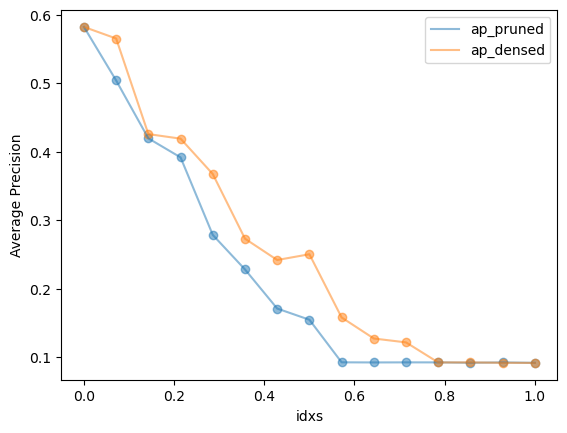

In [23]:
ratios = np.linspace(0, 0.8, 15)

sd = torch.load('./weights/voc_fine_tuned.pt', map_location=torch_device)
ap_pruned, ap_densed, idxs = [], [], []
for idx, ratio in tqdm.tqdm(enumerate(ratios), total=len(ratios)):
    # pruned model
    sd_pruned = l1_structured_pruning(sd, ratio)
    net = TinyYoloV2(num_classes=1)
    ap_pruned.append(test_scratch(net, sd_pruned, test_loader, torch_device))

    # densed model
    sd_densed = densify_state_dict(sd_pruned)
    net = PrunedTinyYoloV2(num_classes=1)
    ap_densed.append(test_scratch(net, sd_densed, test_loader, torch_device))

    idxs.append(idx)
    
plot([(idxs, ap_pruned, 'ap_pruned'), (idxs, ap_densed, 'ap_densed')], xlabel='idxs', save_path='ap_l1_finetuned3-7.png')

In [28]:
print(len(ap_pruned))
print(len(ap_densed))
print(len(idxs))

19
19
19


In [ ]:
model_densed = PrunedTinyYoloV2(num_classes=1)
model_densed.load_state_dict(sd_densed, strict=False)
print(f"\nInference Time after Densifying: {net_time(model_densed, test_loader):.3}")

## Re-Training

In [ ]:
ratios = [0.0] + [0.05 for _ in range(18)]

torch_device = torch.device("cuda")
sd = torch.load('./weights/voc_fine_tuned.pt', map_location=torch_device)
ap_from_scratch, ap_fine_tuned, macs, train_loss = [], [], [], []

# from scratch
for ratio in tqdm.tqdm(ratios):
    # Setting Filters to zero
    sd = l1_structured_pruning(sd, ratio)
    
    # Densifying the state dict
    sd = densify_state_dict(copy.deepcopy(sd))
    
    # AP calculation
    net = PrunedTinyYoloV2(num_classes=1)
    ap_from_scratch.append(test_scratch(net, sd, test_loader, torch_device))

# Retrain pruned layers
sd = torch.load('./weights/voc_fine_tuned.pt', map_location=torch_device)
prev = 0.65
for ratio in tqdm.tqdm(ratios):
    # Setting Filters to zero
    sd = l1_structured_pruning(sd, ratio)
    
    # Densifying the state dict
    sd = densify_state_dict(copy.deepcopy(sd))
    
    # We fine tune the network
    net = PrunedTinyYoloV2(num_classes=1)
    _, ap_ft, sd, loss = fine_tune(net, sd, train_loader, validation_loader, test_loader)
    ap_fine_tuned.append(ap_ft)
    train_loss.append(loss)
    macs.append(net_macs(PrunedTinyYoloV2, sd))

    # Save fine tuned densed network
    torch.save(sd, f"./weights3-7/voc_fine_tuned_pruned3-7{round(prev+ratio, 3)}.pt")
    prev=prev+ratio
    
plot([(macs, ap_from_scratch, 'ap_scratch'),
      (macs, ap_fine_tuned, 'ap_fine_tuned')],
      xlabel='MACs [relative to max]', save_path='ap_macs_finetuned3-7.png')

  0%|          | 0/19 [00:00<?, ?it/s]

Average Precision increased (0.000000 --> 0.335309). Saving model...
Average Precision increased (0.335309 --> 0.362410). Saving model...
EarlyStopping counter: 1 out of 5
Average Precision increased (0.362410 --> 0.385104). Saving model...
Average Precision increased (0.385104 --> 0.386614). Saving model...
Average Precision increased (0.386614 --> 0.391223). Saving model...
Average Precision increased (0.391223 --> 0.402681). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5


  5%|▌         | 1/19 [51:18<15:23:34, 3078.58s/it]

Average Precision increased (0.000000 --> 0.318606). Saving model...
Average Precision increased (0.318606 --> 0.366937). Saving model...
EarlyStopping counter: 1 out of 5
Average Precision increased (0.366937 --> 0.384797). Saving model...
Average Precision increased (0.384797 --> 0.404810). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5


 11%|█         | 2/19 [1:34:08<13:07:26, 2779.18s/it]

Average Precision increased (0.000000 --> 0.273469). Saving model...
Average Precision increased (0.273469 --> 0.308099). Saving model...
Average Precision increased (0.308099 --> 0.342184). Saving model...
Average Precision increased (0.342184 --> 0.356654). Saving model...
Average Precision increased (0.356654 --> 0.385590). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5


 16%|█▌        | 3/19 [2:17:09<11:57:00, 2688.79s/it]

Average Precision increased (0.000000 --> 0.265218). Saving model...
Average Precision increased (0.265218 --> 0.306253). Saving model...
Average Precision increased (0.306253 --> 0.322441). Saving model...
Average Precision increased (0.322441 --> 0.350701). Saving model...
Average Precision increased (0.350701 --> 0.381960). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5


 21%|██        | 4/19 [2:59:32<10:57:50, 2631.38s/it]

Average Precision increased (0.000000 --> 0.263129). Saving model...
Average Precision increased (0.263129 --> 0.309128). Saving model...
Average Precision increased (0.309128 --> 0.313458). Saving model...
Average Precision increased (0.313458 --> 0.317194). Saving model...
Average Precision increased (0.317194 --> 0.355814). Saving model...
Average Precision increased (0.355814 --> 0.373647). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5


 26%|██▋       | 5/19 [3:46:13<10:28:14, 2692.47s/it]

Average Precision increased (0.000000 --> 0.261370). Saving model...
Average Precision increased (0.261370 --> 0.319211). Saving model...
EarlyStopping counter: 1 out of 5
Average Precision increased (0.319211 --> 0.319668). Saving model...
Average Precision increased (0.319668 --> 0.371330). Saving model...
Average Precision increased (0.371330 --> 0.375264). Saving model...


19
19
19


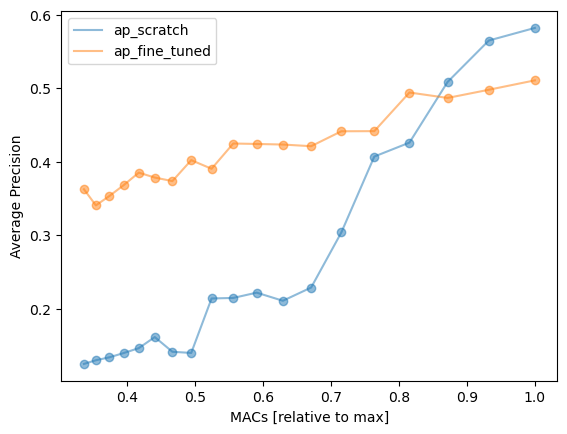

In [40]:
print(len(ap_from_scratch))
print(len(ap_fine_tuned))
print(len(macs))

plot([(macs, ap_from_scratch, 'ap_scratch'),
      (macs, ap_fine_tuned, 'ap_fine_tuned')],
      xlabel='MACs [relative to max]', save_path='ap_macs_finetuned3-7.png')

# Fused model

In [27]:
torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sd_fused = torch.load('./weights/fused_voc_fine_tuned.pt', weights_only=True, map_location=torch_device)

model_fused = FusedTinyYoloV2(num_classes=1)
model_fused.load_state_dict(sd_fused, strict=False)

<All keys matched successfully>

In [28]:
print(f"\nInference Time before Pruning: {net_time(model_fused, test_loader):.3}")


Inference Time before Pruning: 3.68


## L1 Pruning

100%|██████████| 15/15 [56:14<00:00, 224.99s/it] 


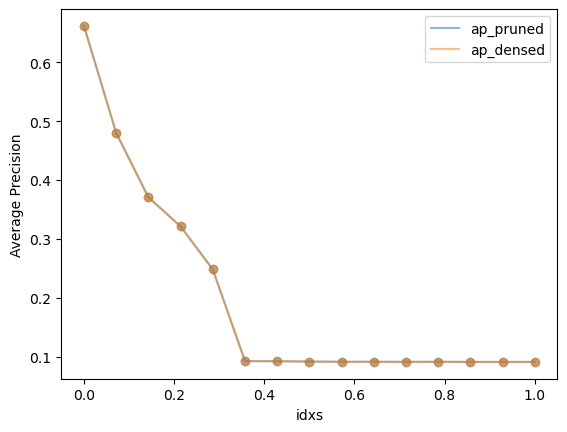

In [41]:
ratios = np.linspace(0, 0.8, 15)

sd = torch.load('./weights/fused_voc_fine_tuned.pt', map_location=torch_device)
ap_pruned, ap_densed, idxs = [], [], []
for idx, ratio in tqdm.tqdm(enumerate(ratios), total=len(ratios)):
    # pruned model
    sd_fused_pruned = l1_structured_fused_pruning(sd, ratio)
    net = FusedTinyYoloV2(num_classes=1)
    ap_pruned.append(test_scratch(net, sd_fused_pruned, test_loader, torch_device))

    # densed model
    sd_fused_densed = densify_fused_state_dict(sd_fused_pruned)
    net = PrunedFusedTinyYoloV2(num_classes=1)
    ap_densed.append(test_scratch(net, sd_fused_densed, test_loader, torch_device))

    idxs.append(idx)
    
plot([(idxs, ap_pruned, 'ap_pruned'), (idxs, ap_densed, 'ap_densed')], xlabel='idxs', save_path='ap_l1_fused.png')

In [42]:
print(ap_pruned)
print(ap_densed)
print(idxs)

[0.6620041810055146, 0.4803661540619561, 0.3707982275395839, 0.32131268224070114, 0.24816752126837202, 0.09228491296102863, 0.0920672309349641, 0.09152849105540829, 0.09113269472885718, 0.0911590171770024, 0.09106514378569991, 0.09112225437828257, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091]
[0.6620041810055145, 0.4803661208984609, 0.3707972293770057, 0.3213357642477666, 0.2481600707730298, 0.09228786049397192, 0.09206436318044696, 0.09152845231020888, 0.09113174839112999, 0.09115901199267361, 0.09106513013644046, 0.09112222712319977, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [44]:
model_fused_densed = PrunedFusedTinyYoloV2(num_classes=1)
model_fused_densed.load_state_dict(sd_fused_densed, strict=False)
print(f"\nInference Time after Densifying: {net_time(model_fused_densed, test_loader):.3}")


Inference Time after Densifying: 2.88


## Re-Training

In [83]:
ratios = [0.0] + [0.05 for _ in range(13)]

torch_device = torch.device("cuda")
# sd = torch.load('./weights/fused_voc_fine_tuned.pt', map_location=torch_device)
# ap_from_scratch, ap_fine_tuned, macs = [], [], []

# # from scratch
# for ratio in tqdm.tqdm(ratios):
#     # Setting Filters to zero
#     sd = l1_structured_fused_pruning(sd, ratio)
    
#     # Densifying the state dict
#     sd = densify_fused_state_dict(copy.deepcopy(sd))
    
#     # AP calculation
#     net = PrunedFusedTinyYoloV2(num_classes=1)
#     ap_from_scratch.append(test_scratch(net, sd, test_loader, torch_device))

# Retrain pruned layers
ap_fine_tuned, macs = [], []
sd = torch.load('./weights/fused_voc_fine_tuned.pt', map_location=torch_device)
prev = 0
for ratio in tqdm.tqdm(ratios):
    # Setting Filters to zero
    sd = l1_structured_fused_pruning(sd, ratio)
    
    # Densifying the state dict
    sd = densify_fused_state_dict(copy.deepcopy(sd))
    
    # We fine tune the network
    net = PrunedFusedTinyYoloV2(num_classes=1)
    _, ap_ft, sd = fine_tune(net, sd, train_loader, validation_loader, test_loader)
    ap_fine_tuned.append(ap_ft)
    macs.append(net_macs(PrunedFusedTinyYoloV2, sd))

    # Save fine tuned densed network
    torch.save(sd, f"./weights/fused_voc_fine_tuned_pruned{round(prev+ratio, 3)}.pt")
    prev=prev+ratio
    
plot([(macs, ap_from_scratch, 'ap_scratch'),
      (macs, ap_fine_tuned, 'ap_fine_tuned')],
      xlabel='MACs [relative to max]', save_path='ap_macs_fused.png')

  0%|          | 0/14 [00:00<?, ?it/s]

Average Precision increased (0.000000 --> 0.349992). Saving model...
Average Precision increased (0.349992 --> 0.450042). Saving model...
Average Precision increased (0.450042 --> 0.485865). Saving model...
Average Precision increased (0.485865 --> 0.497467). Saving model...
EarlyStopping counter: 1 out of 5
Average Precision increased (0.497467 --> 0.501647). Saving model...
Average Precision increased (0.501647 --> 0.512723). Saving model...
EarlyStopping counter: 1 out of 5
Average Precision increased (0.512723 --> 0.519342). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5


  7%|▋         | 1/14 [58:35<12:41:40, 3515.45s/it]

Average Precision increased (0.000000 --> 0.191861). Saving model...
Average Precision increased (0.191861 --> 0.282417). Saving model...
Average Precision increased (0.282417 --> 0.316082). Saving model...
Average Precision increased (0.316082 --> 0.353567). Saving model...
Average Precision increased (0.353567 --> 0.365738). Saving model...
Average Precision increased (0.365738 --> 0.377381). Saving model...
Average Precision increased (0.377381 --> 0.381521). Saving model...
Average Precision increased (0.381521 --> 0.450295). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5


 14%|█▍        | 2/14 [1:54:01<11:20:51, 3404.26s/it]

Average Precision increased (0.000000 --> 0.091126). Saving model...
Average Precision increased (0.091126 --> 0.091129). Saving model...
Average Precision increased (0.091129 --> 0.091139). Saving model...
Average Precision increased (0.091139 --> 0.091176). Saving model...
Average Precision increased (0.091176 --> 0.091681). Saving model...
Average Precision increased (0.091681 --> 0.091709). Saving model...
Average Precision increased (0.091709 --> 0.092190). Saving model...
Average Precision increased (0.092190 --> 0.092500). Saving model...
Average Precision increased (0.092500 --> 0.318369). Saving model...
EarlyStopping counter: 1 out of 5
Average Precision increased (0.318369 --> 0.360661). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5


 21%|██▏       | 3/14 [2:55:13<10:46:32, 3526.56s/it]

Average Precision increased (0.000000 --> 0.090909). Saving model...
Average Precision increased (0.090909 --> 0.090909). Saving model...
Average Precision increased (0.090909 --> 0.091097). Saving model...
EarlyStopping counter: 1 out of 5
Average Precision increased (0.091097 --> 0.091177). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
Average Precision increased (0.091177 --> 0.091573). Saving model...
Average Precision increased (0.091573 --> 0.091578). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
Average Precision increased (0.091578 --> 0.091620). Saving model...
EarlyStopping counter: 1 out of 5
Average Precision increased (0.091620 --> 0.091627). Saving model...


 29%|██▊       | 4/14 [3:54:52<9:51:09, 3546.94s/it] 

Average Precision increased (0.000000 --> 0.091097). Saving model...
Average Precision increased (0.091097 --> 0.091115). Saving model...
EarlyStopping counter: 1 out of 5
Average Precision increased (0.091115 --> 0.091128). Saving model...
Average Precision increased (0.091128 --> 0.091210). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
Average Precision increased (0.091210 --> 0.091543). Saving model...
Average Precision increased (0.091543 --> 0.091570). Saving model...
Average Precision increased (0.091570 --> 0.091591). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
Average Precision increased (0.091591 --> 0.091596). Saving model...


 36%|███▌      | 5/14 [4:54:52<8:54:55, 3566.20s/it]

Average Precision increased (0.000000 --> 0.091110). Saving model...
EarlyStopping counter: 1 out of 5
Average Precision increased (0.091110 --> 0.091137). Saving model...
Average Precision increased (0.091137 --> 0.091190). Saving model...
Average Precision increased (0.091190 --> 0.091553). Saving model...
EarlyStopping counter: 1 out of 5
Average Precision increased (0.091553 --> 0.091569). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5


 43%|████▎     | 6/14 [5:42:35<7:23:37, 3327.19s/it]

Average Precision increased (0.000000 --> 0.090909). Saving model...
Average Precision increased (0.090909 --> 0.091097). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
Average Precision increased (0.091097 --> 0.091209). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
Average Precision increased (0.091209 --> 0.091475). Saving model...
Average Precision increased (0.091475 --> 0.091552). Saving model...
EarlyStopping counter: 1 out of 5
Average Precision increased (0.091552 --> 0.091565). Saving model...
EarlyStopping counter: 1 out of 5
Average Precision increased (0.091565 --> 0.091600). Saving model...
Average Precision increased (0.091600 --> 0.091619). Saving model...
EarlyStopping counter: 1 out of 5


 50%|█████     | 7/14 [6:43:35<6:40:51, 3435.99s/it]

Average Precision increased (0.000000 --> 0.091085). Saving model...
Average Precision increased (0.091085 --> 0.091089). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
Average Precision increased (0.091089 --> 0.091140). Saving model...
Average Precision increased (0.091140 --> 0.091490). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
Average Precision increased (0.091490 --> 0.091561). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
Average Precision increased (0.091561 --> 0.091585). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5


 57%|█████▋    | 8/14 [7:44:23<5:50:20, 3503.50s/it]

Average Precision increased (0.000000 --> 0.090909). Saving model...
Average Precision increased (0.090909 --> 0.091079). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
Average Precision increased (0.091079 --> 0.091106). Saving model...
Average Precision increased (0.091106 --> 0.091145). Saving model...
EarlyStopping counter: 1 out of 5
Average Precision increased (0.091145 --> 0.091506). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
Average Precision increased (0.091506 --> 0.091525). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
Average Precision increased (0.091525 --> 0.091545). Saving model...


 64%|██████▍   | 9/14 [8:44:28<4:54:35, 3535.07s/it]

Average Precision increased (0.000000 --> 0.091115). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
Average Precision increased (0.091115 --> 0.091144). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
Average Precision increased (0.091144 --> 0.091428). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
Average Precision increased (0.091428 --> 0.091449). Saving model...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5


 71%|███████▏  | 10/14 [11:56:30<4:46:36, 4299.06s/it]


KeyboardInterrupt: 

# Misc

In [47]:
# ratios = [0.0] + [0.025 for _ in range(25)]
ratios = [0.0] + [0.05 for _ in range(18)]

prev = 0;
print(len(ratios))
for i, ratio in enumerate(ratios):
    if i <= 13:
        continue
    print(ratio)
    # print(round(prev+ratio, 3))
    # print(prev+ratio)
    # prev=prev+ratio

19
0.05
0.05
0.05
0.05
0.05
